# Terry Stop Classification Model

A Terry Stop, also known as a "Stop, Question, and Frisk" or a "Stop and Frisk" is based on the Supreme Court case *Terry V. Ohio*. The court in Terry held that a stop and frisk must comply with the Fourth Amendment, meaning that the stop-and-frisk cannot be unreasonable.

![Stop and frisk](./data/th.jpg)

A reasonable stop-and-frisk is one in which a reasonably prudent office is endangered. He/she may make a reasonable search for weapons of the person believed by him to be armed and dangerous.

When an officer has a *reasonable suspicion* that an individual is armed, engaged in, or about to be engaged in criminal conduct, the office may briefly stop and detain an individual for a *pat-down*

In a traffic stop setting, the Terry condition of a lawful investigatory stop is met whenever it is lawful for the police to detain an automobile and its occupants pending inquiry into a vehicular violation. The police do not need to believe that any occupant of the vehicle is involved in criminal activity. The reasonable suspicion of criminal activities discovered during the traffic stop may give rise to a Terry stop.

## Exlporatory Data Analysis
We'll use a number of Datasets, Seattle PD and NYPD. We'll process the data and create a classification that will help predict whether an arrest was made after a Terry Stop.

We'll look at the info and description of the data

### Import the required Datasets and libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_absolute_error, root_mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import tree


#import the seattle PD data and print the first 5 rows
seattle_data = pd.read_csv("./data/Terry_Stops_20241018.csv")
nypd_data = pd.read_excel("./data/NYPD_terry_stops.xlsx")

seattle_data.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,26 - 35,-1,20150000005870,101060,Field Contact,NaN,4980,1962,F,White,...,15:12:00.0000000,-,-,-,WEST PCT 2ND W - QUEEN - PLATOON 1,N,N,-,-,-
1,26 - 35,-1,20150000089918,28823,Arrest,NaN,5143,1957,M,Black or African American,...,19:13:00.0000000,ROBBERY - CRITICAL (INCLUDES STRONG ARM),--ROBBERY - STRONG ARM,911,NaN,N,Y,East,C,C1
2,-,-1,20180000078041,463764,Arrest,NaN,6921,1978,M,Asian,...,04:27:00.0000000,TRESPASS,--WARRANT SERVICES - MISDEMEANOR,911,SOUTH PCT 3RD W - ROBERT - PLATOON 2,N,Y,South,R,R2
3,56 and Above,12770971382,20200000175799,13267969395,Arrest,-,7266,1976,M,White,...,11:17:19.0000000,ASLT - CRITICAL (NO SHOOTINGS),"--ASSAULTS, OTHER",911,WEST PCT 1ST W - KING - PLATOON 1,Y,N,West,K,K1
4,26 - 35,-1,20160000108160,141119,Offense Report,NaN,7288,1984,M,White,...,17:35:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--SUSPICIOUS CIRCUM. - SUSPICIOUS VEHICLE,911,EAST PCT 2ND W - E/G RELIEF,N,N,East,E,E2


In [2]:
seattle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61555 entries, 0 to 61554
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         61555 non-null  object
 1   Subject ID                61555 non-null  int64 
 2   GO / SC Num               61555 non-null  int64 
 3   Terry Stop ID             61555 non-null  int64 
 4   Stop Resolution           61555 non-null  object
 5   Weapon Type               28990 non-null  object
 6   Officer ID                61555 non-null  object
 7   Officer YOB               61555 non-null  int64 
 8   Officer Gender            61555 non-null  object
 9   Officer Race              61555 non-null  object
 10  Subject Perceived Race    61555 non-null  object
 11  Subject Perceived Gender  61555 non-null  object
 12  Reported Date             61555 non-null  object
 13  Reported Time             61555 non-null  object
 14  Initial Call Type     

In [3]:
seattle_data.describe()

,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB
count,6.155500e+04,6.155500e+04,6.155500e+04,61555.000000
mean,7.514672e+09,2.018711e+13,1.258517e+10,1984.135976
std,1.307486e+10,8.549706e+10,1.800415e+10,9.467342
min,-8.000000e+00,-1.000000e+00,2.802000e+04,1900.000000
25%,-1.000000e+00,2.017000e+13,2.413675e+05,1979.000000
50%,-1.000000e+00,2.018000e+13,5.132840e+05,1986.000000
75%,7.755940e+09,2.021000e+13,2.040625e+10,1991.000000
max,6.008468e+10,2.024000e+13,6.008639e+10,2002.000000


The dataset shows that majority of the data are identified as objects, and the data identified as an int dtype does nto provide information for the dataset. We will need to impute and One-hot encode the certain features.

First, we will check for any missing data within the dataset.

In [4]:
seattle_data.isna().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 561
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

Although the data presents only two columns that seem to have missing values. In our initial inspection of the dataset, we can see that there are more that two columns that have missing values. We'll identify the number of unique values per column.

In [5]:
print(seattle_data.nunique())

Subject Age Group               7
Subject ID                  17255
GO / SC Num                 49330
Terry Stop ID               61450
Stop Resolution                 5
Weapon Type                    22
Officer ID                   1391
Officer YOB                    56
Officer Gender                  3
Officer Race                   13
Subject Perceived Race         11
Subject Perceived Gender        7
Reported Date                3504
Reported Time               24063
Initial Call Type             182
Final Call Type               199
Call Type                       8
Officer Squad                 272
Arrest Flag                     2
Frisk Flag                      3
Precinct                        9
Sector                         20
Beat                           55
dtype: int64


Based on the dataset description, "Arrest Flag" indicates whether a "physical arrest" was made during the Terry Stop. We'll use this as our target.

In [6]:
seattle_data['Arrest Flag'].value_counts()

Arrest Flag
N    54851
Y     6704
Name: count, dtype: int64

"Arrest Flag" column procides a binary classification, but it needs to be encoded. I also noticed an imbalance in the target. We'll tackle this later on. Let's identify any missing values in the series.

In [7]:
print(seattle_data['Arrest Flag'].isnull().sum())


0


## Simple VIsualizations

We'll perform some simple visualizations to start to get an idea of the data provided.

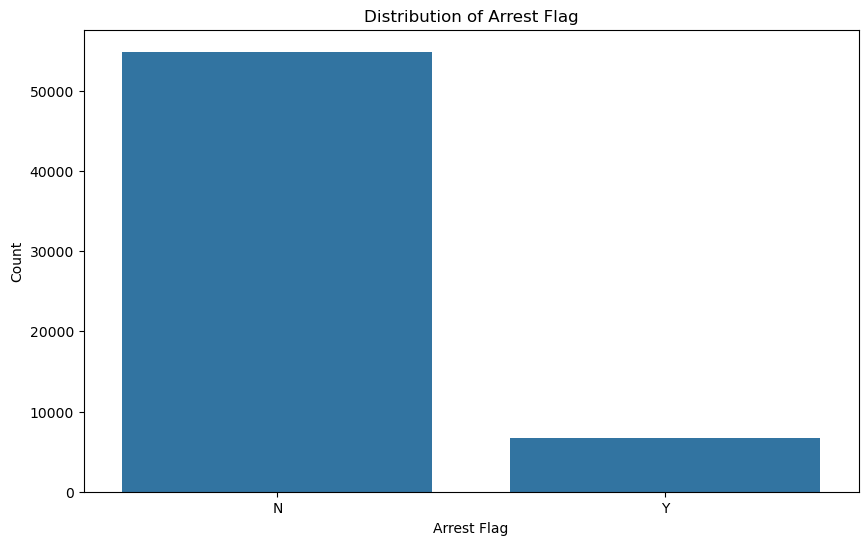

In [8]:
plt.figure(figsize=(10,6))

sns.countplot(data=seattle_data, x=seattle_data['Arrest Flag'])
plt.title("Distribution of Arrest Flag")
plt.xlabel("Arrest Flag")
plt.ylabel("Count")
plt.show()

This shows the count of each class in Arrest Flag. A large difference in counts between classes indicates an imbalance.

In [9]:
arrest_data = seattle_data[seattle_data['Arrest Flag'] == 'Y']
arrest_data

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
3,56 and Above,12770971382,20200000175799,13267969395,Arrest,-,7266,1976,M,White,...,11:17:19.0000000,ASLT - CRITICAL (NO SHOOTINGS),"--ASSAULTS, OTHER",911,WEST PCT 1ST W - KING - PLATOON 1,Y,N,West,K,K1
13,26 - 35,7727677416,20200000162912,13175704162,Arrest,-,8644,1995,M,Two or More Races,...,22:29:44.0000000,TRESPASS,--PROWLER - TRESPASS,"TELEPHONE OTHER, NOT 911",NORTH PCT 3RD W - UNION - PLATOON 1,Y,N,North,U,U1
35,18 - 25,31629644948,20220000135691,34067259361,Arrest,-,8554,1990,M,White,...,09:38:37.0000000,ASLT - DV CRITICAL,"--DV - ARGUMENTS, DISTURBANCE (NO ARREST)",911,NORTH PCT 1ST W - BOY (JOHN) - PLATOON 1,Y,N,North,B,B1
38,26 - 35,56845206186,20240000196562,57680658476,Arrest,-,8874,1998,M,Hispanic,...,01:36:07.0000000,DISTURBANCE - DV CRITICAL,--DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),911,EAST PCT 3RD W - GEORGE (CHARLIE) - PLATOON 1,Y,Y,East,G,G1
55,36 - 45,7704469768,20190000454001,12034401373,Arrest,-,8626,1992,M,White,...,10:56:31.0000000,FIGHT - CRITICAL WITH WEAPONS,"--ASSAULTS, OTHER",ONVIEW,WEST PCT 1ST W - KING - PLATOON 1,Y,N,West,K,K2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,18 - 25,34603052213,20220000170465,34603243727,Arrest,Blunt Object/Striking Implement,8377,1983,M,White,...,16:57:43.0000000,DISTURBANCE,--DISTURBANCE - OTHER,911,EAST PCT 2ND W - CHARLIE - PLATOON 2,Y,Y,East,C,C1
61532,26 - 35,7735857164,20210000284684,29319133500,Arrest,-,8768,1988,M,Asian,...,00:05:08.0000000,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),911,WEST PCT 3RD W - KING - PLATOON 1,Y,Y,West,K,K3
61533,18 - 25,7741755512,20240000210107,57961741719,Arrest,Taser/Stun Gun,8897,1987,M,White,...,05:21:37.0000000,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--BURGLARY - NON RESIDENTIAL/COMMERCIAL,911,EAST PCT 3RD W - GEORGE - PLATOON 2,Y,Y,East,G,G1
61542,36 - 45,7728211859,20210000118981,24057502078,Arrest,-,8633,1988,M,Black or African American,...,15:25:28.0000000,BURG - OCCUPIED RESD,--PROWLER - TRESPASS,911,WEST PCT 2ND W - K/Q RELIEF,Y,Y,West,Q,Q2


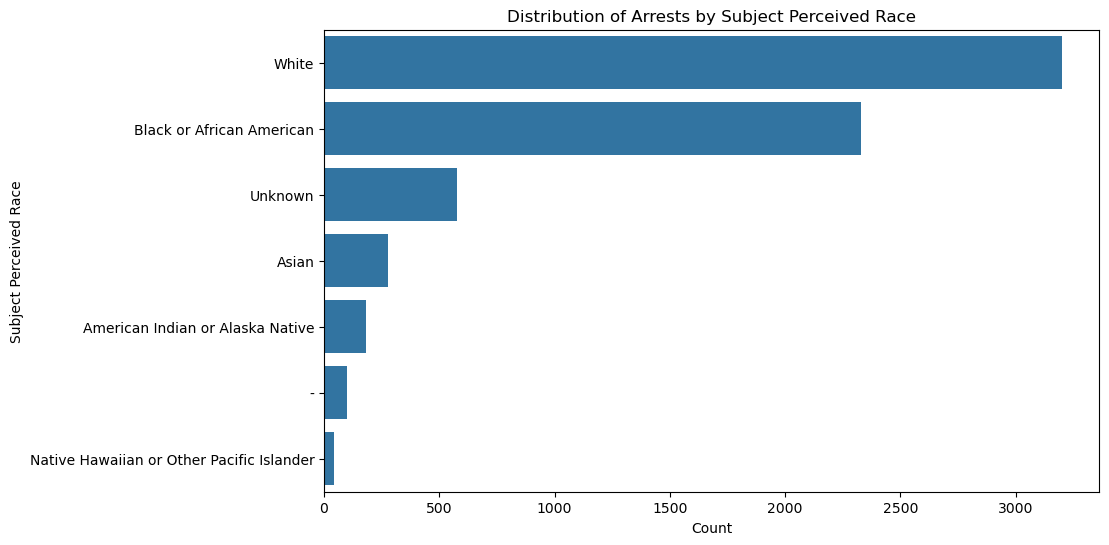

In [10]:
# Plot arrests by race
plt.figure(figsize=(10, 6))
sns.countplot(y="Subject Perceived Race", data=arrest_data, order=arrest_data["Subject Perceived Race"].value_counts().index)
plt.title("Distribution of Arrests by Subject Perceived Race")
plt.xlabel("Count")
plt.ylabel("Subject Perceived Race")
plt.show()

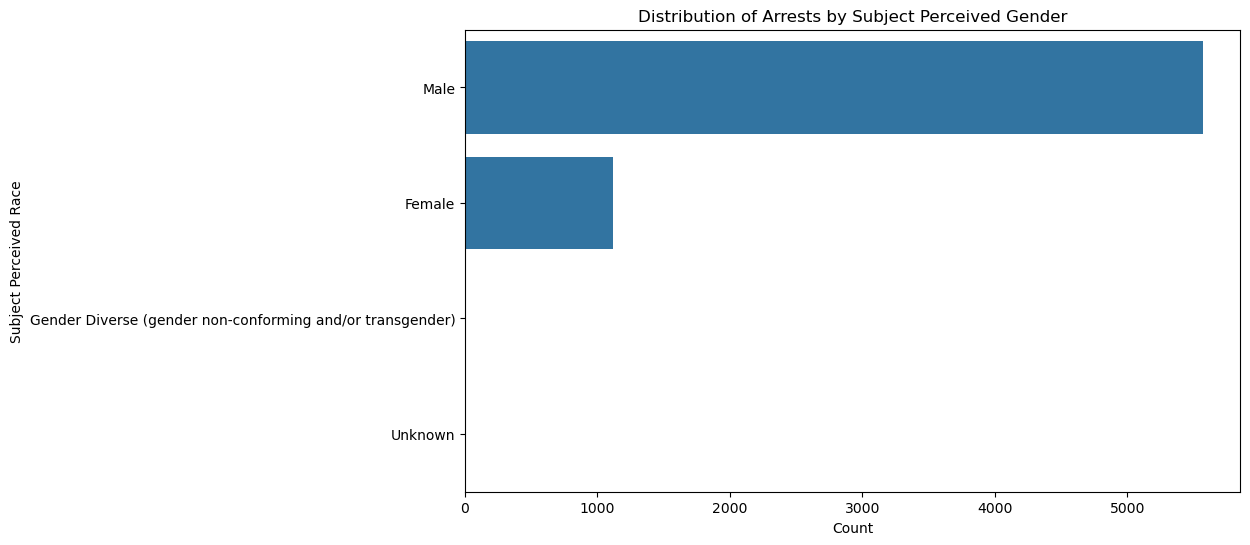

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(y="Subject Perceived Gender", data=arrest_data, order=arrest_data["Subject Perceived Gender"].value_counts().index)
plt.title("Distribution of Arrests by Subject Perceived Gender")
plt.xlabel("Count")
plt.ylabel("Subject Perceived Race")
plt.show()

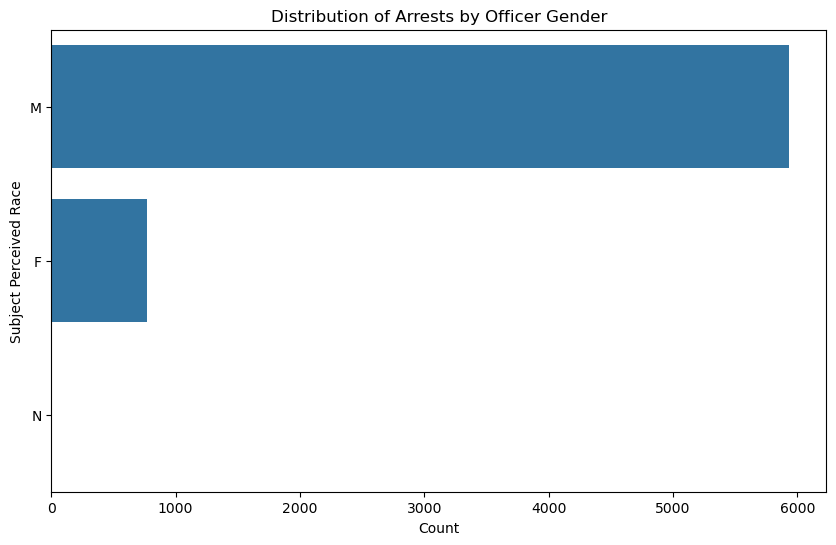

In [12]:
# Plot arrests by race
plt.figure(figsize=(10, 6))
sns.countplot(y="Officer Gender", data=arrest_data, order=arrest_data["Officer Gender"].value_counts().index)
plt.title("Distribution of Arrests by Officer Gender")
plt.xlabel("Count")
plt.ylabel("Subject Perceived Race")
plt.show()

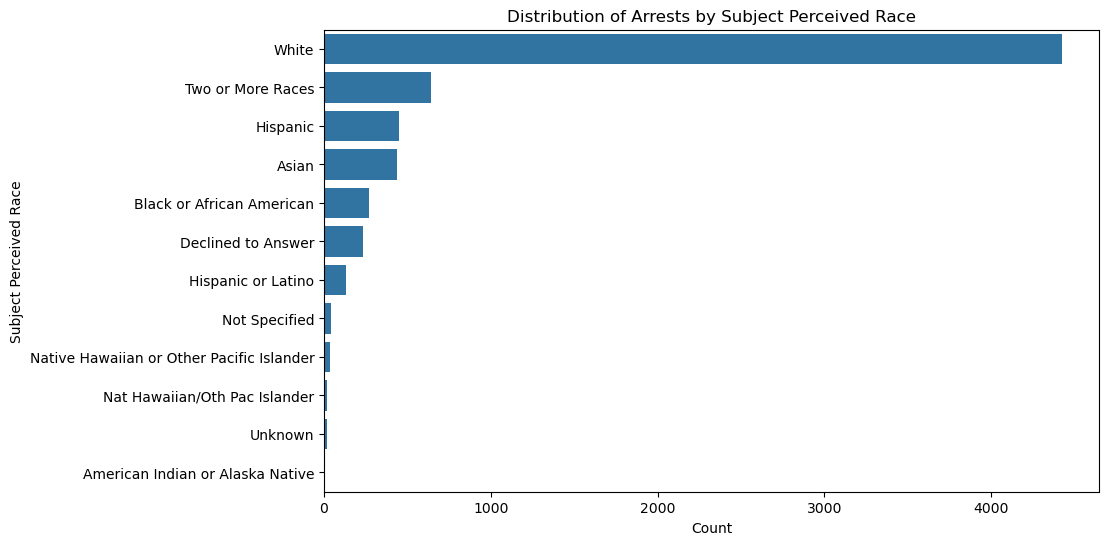

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(y="Officer Race", data=arrest_data, order=arrest_data["Officer Race"].value_counts().index)
plt.title("Distribution of Arrests by Subject Perceived Race")
plt.xlabel("Count")
plt.ylabel("Subject Perceived Race")
plt.show()

We'll use the features 'Final Call Type','Stop Resolution','Officer Gender', 'Officer Race','Subject Perceived Gender', 'Subject Perceived Race', and'Frisk Flag' to perform our model as I feel as these will ead to a random stop and arrest.

We'll split the data afterwards.

In [14]:
# features = ['Subject Age Group', 'Weapon Type', 'Officer YOB','Officer Gender', 'Officer Race', 'Subject Perceived Race','Initial Call Type', 'Precinct']
features = ['Final Call Type','Stop Resolution','Officer Gender', 'Officer Race','Subject Perceived Gender', 'Subject Perceived Race','Frisk Flag']
feature_data = seattle_data[features]
X = feature_data
y = seattle_data['Arrest Flag']

In [15]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=3, test_size=0.2)

In [16]:
print(f"X_train for the seattle dataset is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} colums.")
print(f"y_train for seattle dataset is a Series with {y_train.shape[0]} values.")

X_train for the seattle dataset is a DataFrame with 49244 rows and 7 colums.
y_train for seattle dataset is a Series with 49244 values.


In [17]:
X_train.dtypes

Final Call Type             object
Stop Resolution             object
Officer Gender              object
Officer Race                object
Subject Perceived Gender    object
Subject Perceived Race      object
Frisk Flag                  object
dtype: object

Let's change the column names to a more conventional style. I'll create a function that will for the columns.

In [18]:
def reformat_columns(data, return_type='dataframe'):
    '''Function that reformat the columns.
    adding an underscore to the naming convention and lowering the font'''
    if isinstance(data, pd.DataFrame):
        # Reformat columns for DataFrame
        formatted_columns = data.rename(columns=lambda x: x.replace(' ', '_').lower())
        if return_type == "dataframe":
            return formatted_columns
        elif return_type == "series":
            return formatted_columns.columns.to_series()
        else:
            raise ValueError("return_type must be either 'dataframe' or 'series' when data is a DataFrame.")
            
      # Check if the input is a Series
    elif isinstance(data, pd.Series):
        # Reformat the Series name if it has one
        formatted_columns = data.rename(data.name.replace(' ', '_').lower() if data.name else None)
    return formatted_columns

In [19]:
#Let's change the string style to a more conventional style
X_train = reformat_columns(X_train)
X_train.columns

Index(['final_call_type', 'stop_resolution', 'officer_gender', 'officer_race',
       'subject_perceived_gender', 'subject_perceived_race', 'frisk_flag'],
      dtype='object')

In [20]:
y_train = reformat_columns(y_train)
y_train.name

'arrest_flag'

In [21]:
X_test = reformat_columns(X_test)
X_test.columns

Index(['final_call_type', 'stop_resolution', 'officer_gender', 'officer_race',
       'subject_perceived_gender', 'subject_perceived_race', 'frisk_flag'],
      dtype='object')

In [22]:
y_test = reformat_columns(y_test)
y_test.name

'arrest_flag'

We start by imputing the data, this will account for any missing values in the train and test set.

In [23]:
X_train = X_train.replace(['None','-','N/A','Unknown','Unable to Determine','Not Specified'],np.nan)
X_test= X_test.replace(['None','-','N/A','Unknown','Unable to Determine','Not Specified'], np.nan)

In [24]:
imputer = SimpleImputer(strategy='constant', fill_value=None)
imputer.fit(X_train)


# transform the features
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_imputed_df = pd.DataFrame(X_train_imputed,
                                columns=X_train.columns, 
                                index=X_train.index
                                )


X_test_imputed_df = pd.DataFrame(X_test_imputed, 
                                columns=X_test.columns, 
                                index=X_test.index
                                )

    



In [25]:
# X_train_categorical_imputer = impute_data_with_target(X_train, X_test)
X_train_imputed_df

,final_call_type,stop_resolution,officer_gender,officer_race,subject_perceived_gender,subject_perceived_race,frisk_flag
37396,--DISTURBANCE - OTHER,Offense Report,M,White,Male,White,Y
7786,--THEFT - SHOPLIFT,Offense Report,M,Black or African American,Male,Black or African American,N
16995,--WARRANT SERVICES - MISDEMEANOR,Arrest,M,White,Male,Black or African American,Y
55912,--DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),Arrest,M,White,Male,missing_value,N
31610,--AUTOMOBILES - LICENSE PLATE(S) THEFT OR LOSS,Field Contact,M,White,Male,White,N
...,...,...,...,...,...,...,...
48056,"--WEAPON, PERSON WITH - GUN",Field Contact,M,White,Female,missing_value,N
59011,--PROPERTY DEST (DAMG),Offense Report,F,Black or African American,Male,White,N
11513,missing_value,Arrest,M,Black or African American,Female,White,N
1688,--TRAFFIC - D.U.I.,Arrest,M,White,Female,White,N


Check each column in the dataframe and 

In [26]:
for val in X_train_imputed_df.columns:
    print(X_train[[val]].value_counts().sort_values(ascending=True))
    print()

final_call_type                         
--PREMISE CHECKS - REQUEST TO WATCH            1
RAPE                                           1
UNKNOWN - COMPLAINT OF UNKNOWN NATURE          1
ROBBERY (INCL STRONG ARM)                      1
--ALARM-VEHICLE ALARMS                         1
                                            ... 
--WARRANT SERVICES - FELONY                 1745
--ASSAULTS, OTHER                           2435
--DISTURBANCE - OTHER                       2951
--PROWLER - TRESPASS                        3479
--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON    4536
Name: count, Length: 190, dtype: int64

stop_resolution         
Citation / Infraction         173
Referred for Prosecution      588
Arrest                      11945
Offense Report              12621
Field Contact               23917
Name: count, dtype: int64

officer_gender
N                    25
F                  5606
M                 43613
Name: count, dtype: int64

officer_race                             
Am

In [27]:
X_train_imputed_df.isna().sum()

final_call_type             0
stop_resolution             0
officer_gender              0
officer_race                0
subject_perceived_gender    0
subject_perceived_race      0
frisk_flag                  0
dtype: int64

In [28]:
X_test_imputed_df

,final_call_type,stop_resolution,officer_gender,officer_race,subject_perceived_gender,subject_perceived_race,frisk_flag
36992,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,Field Contact,M,White,Male,White,Y
61480,missing_value,Field Contact,F,White,Male,Black or African American,N
32955,--BURGLARY - RESIDENTIAL OCCUPIED,Arrest,M,White,Male,White,N
38484,"--ARSON, BOMBS, EXPLO - RECKLESS BURNING",Arrest,M,Two or More Races,Male,White,N
60377,--CRISIS COMPLAINT - GENERAL,Field Contact,M,Black or African American,Female,White,N
...,...,...,...,...,...,...,...
58266,missing_value,Field Contact,M,Hispanic,Male,White,N
46339,--BURGLARY - NON RESIDENTIAL/COMMERCIAL,Arrest,M,White,Male,Black or African American,N
31647,missing_value,Field Contact,F,Two or More Races,Male,White,N
35209,--THEFT - CAR PROWL,Field Contact,M,White,Male,missing_value,N


# One-Hot Encoder
We'll perform one-hot encoding on the categorical variables

## Normalize the target for the train and test

In [29]:
y_train

37396    N
7786     N
16995    Y
55912    Y
31610    N
        ..
48056    N
59011    N
11513    N
1688     N
5994     N
Name: arrest_flag, Length: 49244, dtype: object

In [30]:
from sklearn.preprocessing import LabelEncoder

#create an instance of StandardScaler
encoder = LabelEncoder()

# Fit and transform train
y_train_encoded = encoder.fit_transform(y_train)

# Transofrm test
y_test_encoded = encoder.transform(y_test)

#convert to a Series
y_train_encoded_series = pd.Series(y_train_encoded, index=y_train.index, name=y_train.name)

y_test_encoded_series = pd.Series(y_test_encoded, index=y_test.index, name=y_test.name)

0 = No, 1 = Yes

This allowed us to encode our target to a binary classification?

In [31]:
y_test_encoded_series

36992    0
61480    0
32955    0
38484    1
60377    0
        ..
58266    0
46339    1
31647    0
35209    0
620      0
Name: arrest_flag, Length: 12311, dtype: int32

In [32]:

def one_hot_encode(train_data, test_data, drop='first', handle_unknown='ignore'):
    """
    Perform one-hot encoding on the categorical columns of train and test datasets.
    
    Parameters:
    - train_data (pd.DataFrame): The training dataset with categorical columns.
    - test_data (pd.DataFrame): The test dataset with categorical columns.
    - drop (str): Specifies a method to drop one of the levels. Default is 'first'.
    - handle_unknown (str): Specifies how to handle unknown categories. Default is 'ignore'.
    
    Returns:
    - train_encoded_df (pd.DataFrame): One-hot encoded training data as a DataFrame.
    - test_encoded_df (pd.DataFrame): One-hot encoded test data as a DataFrame.
    - encoded_columns (list): List of encoded column names.
    """
    # One-Hot Encoding on the ordinal encoded training data
    
    ohe = OneHotEncoder(sparse_output=False, drop=drop, handle_unknown=handle_unknown)
    
    # Ensure only the columns without unknown values are passed to OneHotEncoder
    X_train_encoder = ohe.fit_transform(train_data)
    
    # Apply One-Hot Encoding to the test data
    X_test_encoder = ohe.transform(test_data)
    
    # Get the encoded feature names
    encoded_columns = ohe.get_feature_names_out(input_features=train_data.columns)
    
    # Convert to DataFrames
    train_encoded_df = pd.DataFrame(X_train_encoder, columns=encoded_columns, index=train_data.index)
    test_encoded_df = pd.DataFrame(X_test_encoder, columns=encoded_columns, index=test_data.index)

    return train_encoded_df, test_encoded_df, encoded_columns

X_train_encoded_df, X_test_encoded_df, encoded_columns = one_hot_encode(X_train_imputed_df, X_test_imputed_df)


c:\Users\omend\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [33]:
X_test_encoded_df

,"final_call_type_--ALARM-COMM ROBB (BANK, PANIC, DURESS)","final_call_type_--ALARM-OTHER (VARDA,PDT,FIRE,LOCAL,METRO,ETC))",final_call_type_--ALARM-RESIDENTIAL BURG,final_call_type_--ALARM-RESIDENTIAL PANIC OR DURESS,final_call_type_--ALARM-VEHICLE ALARMS,"final_call_type_--ANIMAL COMPLAINT - INJURED,DEAD,DANGEROUS","final_call_type_--ANIMAL COMPLAINT - NOISE,STRAY,BITE","final_call_type_--ARSON, BOMBS, EXPLO - ARSON","final_call_type_--ARSON, BOMBS, EXPLO - RECKLESS BURNING","final_call_type_--ARSON,BOMBS,EXPLO - BOMBS, EXPLO,LARGE FIREWORKS",...,subject_perceived_race_Black or African American,subject_perceived_race_Hispanic,subject_perceived_race_MULTIPLE SUBJECTS,subject_perceived_race_Multi-Racial,subject_perceived_race_Native Hawaiian or Other Pacific Islander,subject_perceived_race_Other,subject_perceived_race_White,subject_perceived_race_missing_value,frisk_flag_Y,frisk_flag_missing_value
36992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
61480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
38484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
46339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [34]:
X_train_encoded_df

,"final_call_type_--ALARM-COMM ROBB (BANK, PANIC, DURESS)","final_call_type_--ALARM-OTHER (VARDA,PDT,FIRE,LOCAL,METRO,ETC))",final_call_type_--ALARM-RESIDENTIAL BURG,final_call_type_--ALARM-RESIDENTIAL PANIC OR DURESS,final_call_type_--ALARM-VEHICLE ALARMS,"final_call_type_--ANIMAL COMPLAINT - INJURED,DEAD,DANGEROUS","final_call_type_--ANIMAL COMPLAINT - NOISE,STRAY,BITE","final_call_type_--ARSON, BOMBS, EXPLO - ARSON","final_call_type_--ARSON, BOMBS, EXPLO - RECKLESS BURNING","final_call_type_--ARSON,BOMBS,EXPLO - BOMBS, EXPLO,LARGE FIREWORKS",...,subject_perceived_race_Black or African American,subject_perceived_race_Hispanic,subject_perceived_race_MULTIPLE SUBJECTS,subject_perceived_race_Multi-Racial,subject_perceived_race_Native Hawaiian or Other Pacific Islander,subject_perceived_race_Other,subject_perceived_race_White,subject_perceived_race_missing_value,frisk_flag_Y,frisk_flag_missing_value
37396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
55912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Save the new Data.

In [35]:
X_train_encoded_df.to_csv('./data/X_train_df.csv')

In [36]:
X_test_encoded_df.to_csv('./data/X_test_df.csv')

Try to find the best correlation between the features and the target

In [37]:
# Calculate correlations for each feature in X_train_encoded_df with y_train_encoded_series
target_correlation = X_train_encoded_df.corrwith(y_train_encoded_series)

# Convert to DataFrame for easier visualization
correlation_df = target_correlation.to_frame(name="Correlation with Target")

# Get the top 5 features with the closest (highest absolute) correlation to the target
top_10_features = correlation_df['Correlation with Target'].abs().nlargest(15).index
top_10_correlation_df = correlation_df.loc[top_10_features].sort_values(by="Correlation with Target", ascending=False)
top_10_correlation_df

,Correlation with Target
final_call_type_--TRAFFIC - D.U.I.,0.117901
final_call_type_--DV - DOMESTIC VIOL/ASLT (ARREST MANDATORY),0.116026
"final_call_type_--ASSAULTS, OTHER",0.113199
"final_call_type_--ASSAULTS - HARASSMENT, THREATS",0.105179
frisk_flag_Y,0.105066
final_call_type_--BURGLARY - NON RESIDENTIAL/COMMERCIAL,0.093751
final_call_type_--WARRANT SERVICES - FELONY,0.092340
final_call_type_--BURGLARY - RESIDENTIAL OCCUPIED,0.077093
subject_perceived_race_Hispanic,-0.058233
final_call_type_--PROWLER - TRESPASS,-0.058940


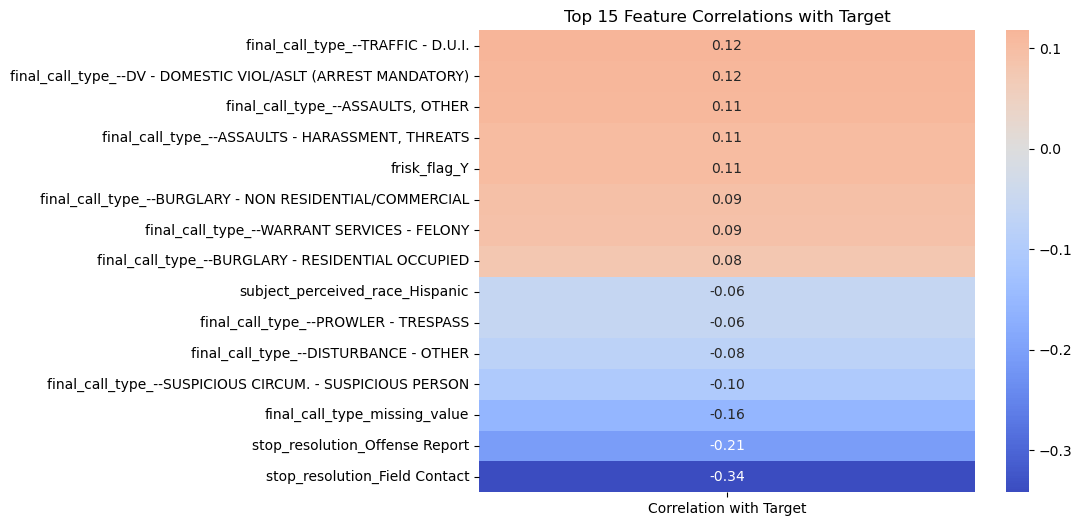

In [38]:
# Plot the correlations of top 5 features
plt.figure(figsize=(8, 6))
sns.heatmap(top_10_correlation_df, annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f")
plt.title("Top 15 Feature Correlations with Target")
plt.show()

## Train a vanilla classfier

We will use a Linear Regression to start to have a base and see the differences as we create or model. We will later use Logistic Resgression, and a decision tree to obtain maximum results. 

R-Squared: 0.3866919080980493
Mean Absolute Error: 0.13828539372461002
Mean Squared Error: 0.057412939579500825
Root Squared Mean Error: 0.2396099738731692
R-Squared: 0.3866919080980493


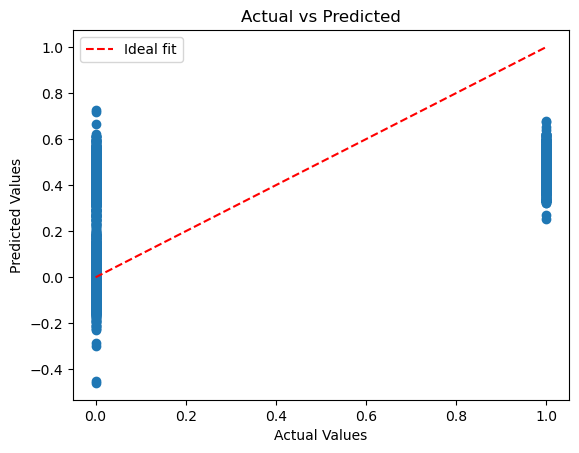

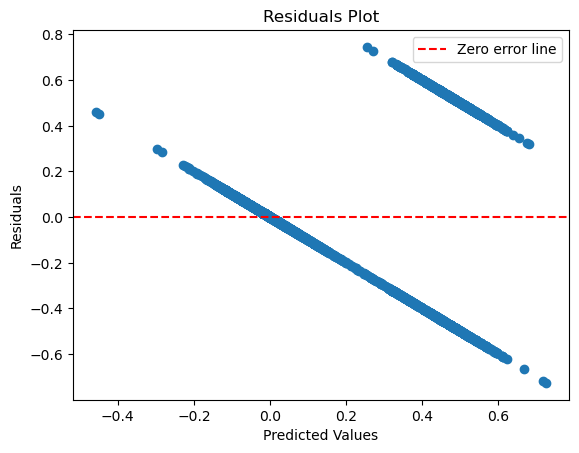

In [39]:
model = LinearRegression().fit(X_train_encoded_df, y_train_encoded_series)

y_prediction = model.predict(X_test_encoded_df)
# R-squared
r_squared = model.score(X_test_encoded_df, y_test_encoded_series)


print(f"R-Squared: {r_squared}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_encoded_series, y_prediction)}")
print(f"Mean Squared Error: {np.sum(np.power(y_test_encoded_series- y_prediction, 2))/len(y_test_encoded_series)}")
print(f"Root Squared Mean Error: {root_mean_squared_error(y_test_encoded_series, y_prediction)}")
print(f"R-Squared: {r2_score(y_test_encoded_series, y_prediction)}")

plt.scatter(y_test_encoded_series, y_prediction)
plt.plot([min(y_test_encoded_series), max(y_test_encoded_series)], [min(y_test_encoded_series), max(y_test_encoded_series)], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

#Residuals
residuals = y_test_encoded_series - y_prediction

plt.scatter(y_prediction, residuals)
plt.axhline(y=0, color='red', linestyle='--', label='Zero error line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.show()

Based on the metric output we can see the following:

* R-Squared: 39%

    This model presents only 39% of the variance in the target, explained by the features. Which indicates a relatively weak fit of the model to the data.

* Mean Absolute Error: 14%

    The MAE shows us the differnce between the predicted and actual values. This may indicate a better accuracy.

* Mean Squared Error(MSE): 6%

    The predicitions and the actual values is 6%

* Root Mean Squared Error: 24%

    The model predictions are off by 24% using the curent model

Based on the metrics, and the visualizations. We can see that this model is not a good fit to predict future data.

Next, we will a Logistic Regression Model and attempt to get better results.

In [40]:
logreg = LogisticRegression(random_state=23, max_iter=1000)

logreg.fit(X_train_encoded_df, y_train_encoded_series)

y_predict = logreg.predict(X_test_encoded_df)



# Calculate evaluation metrics
logreg_accuracy = accuracy_score(y_test_encoded_series, y_predict)
logreg_precision = precision_score(y_test_encoded_series, y_predict, pos_label=1)
logreg_recall = recall_score(y_test_encoded_series, y_predict, pos_label=1)
logreg_f1 = f1_score(y_test_encoded_series, y_predict, pos_label=1)

# Probabilities
y_probabilites = logreg.predict_proba(X_test_encoded_df)[:,1]

false_positive, true_positive, thresholds = roc_curve(y_test_encoded_series, y_probabilites)

roc_auc = auc(false_positive, true_positive)



# Display results

print(f"Accuracy: {logreg_accuracy}")
print(f"Precision: {logreg_precision}")
print(f"Recall:  {logreg_recall}")
print(f"F1 Score: {logreg_f1}")
print(f"ROC AUC Score: {roc_auc}")
print()

# Confusion Matrix
logreg_conf_matrix = confusion_matrix(y_test_encoded_series, y_predict)
print("Confusion Matrix:\n", logreg_conf_matrix)

Accuracy: 0.9134107708553326
Precision: 0.5926236378876781
Recall:  0.5493395493395493
F1 Score: 0.5701612903225807
ROC AUC Score: 0.9530561913090941

Confusion Matrix:
 [[10538   486]
 [  580   707]]


These metrics provide the following:

* Accuracy: 91%

An Accuracy score of  91% means that the number of prodictions made by the model are correct. Although, because this dataset is imbalanced, it's not a good measure to use 

* Precision: 59%

Precision prediction means that 59% of the instances the model predicted as positive are actually positive. This suggests a moderate ability of the model to avoid false positives.

* Recall: 54%

This means that the model correctly identified 54% of the actual positive cases. This indicates that the model is missing 45% of positive cases.

* F1 SCore: 57%

This suggest that while precision and recall are somewhat moderate, they're not optimal. The score represents a balance between the two metrics. The higher F1 score, would indicate a better balance of precision and recall.

* ROC AUC Score: 95%

This is excellent, this means the model is very good at distinguishing between the positive and negative classes. A strong performance overall.



Accuracy is high, but this could be misleading if the dataset is imbalanced, as it doesn't consider the trade-off between false positives and false negatives.

Precision and Recall are somewhat moderate, meaning the model is not perfect in either identifying positive cases or avoiding false positives.


F1 Score is in the middle, indicating that there is room for improvement in balancing precision and recall.
ROC AUC is excellent, showing that the model has a good ability to distinguish between classes.

## Logisitic Visualizations

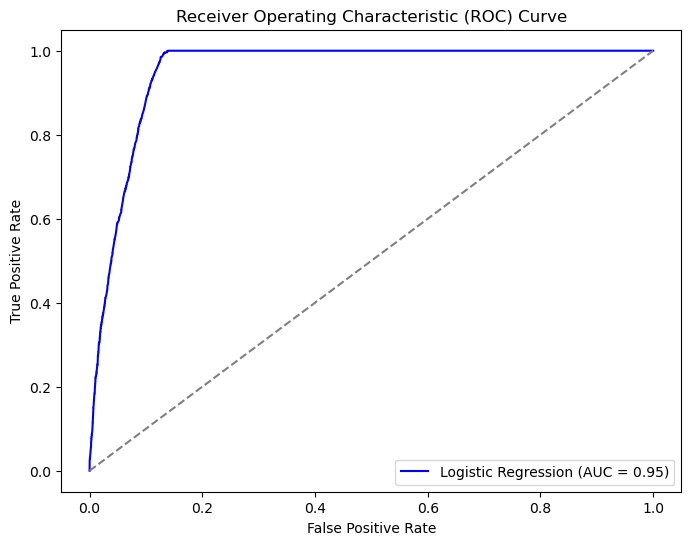

ROC AUC Score: <function roc_curve at 0x000001FA1155F240>


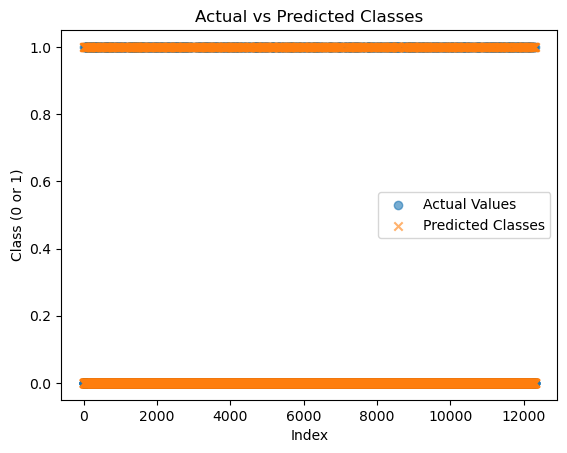

In [41]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive, true_positive, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Display AUC score
print(f"ROC AUC Score: {roc_curve}")


y_pred_classes = (y_predict > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

plt.scatter(range(len(y_test_encoded_series)), y_test_encoded_series, label='Actual Values', marker='o', alpha=0.6)
plt.scatter(range(len(y_pred_classes)), y_pred_classes, label='Predicted Classes', marker='x', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('Class (0 or 1)')
plt.title('Actual vs Predicted Classes')
plt.legend()
plt.show()

In [42]:
y_test_encoded_series.to_csv('./data/y_test.csv')


In [43]:
y_probabilities_df = pd.DataFrame(y_probabilites, columns=['Predicted_Probability'])

# Export to CSV
y_probabilities_df.to_csv('y_probabilities.csv', index=False)

Next we will use a Decision Tree Classifier to improve the models performance

In [44]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=3, max_depth=5).fit(X_train_encoded_df, y_train_encoded_series)

### Make Predictions

In [45]:
#make predictions
y_pred = dt.predict(X_test_encoded_df)

In [46]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
y_test_encoded_series

36992    0
61480    0
32955    0
38484    1
60377    0
        ..
58266    0
46339    1
31647    0
35209    0
620      0
Name: arrest_flag, Length: 12311, dtype: int32

In [48]:

# Accuracy
accuracy = accuracy_score(y_test_encoded_series, y_pred)

precision = precision_score(y_test_encoded_series, y_pred)

recall = recall_score(y_test_encoded_series, y_pred)

f1 = f1_score(y_test_encoded_series, y_pred)

confus_matrix = confusion_matrix(y_test_encoded_series,y_pred)

print("Decision Tree Performance:\n")
print(f"Accuracy: {accuracy}\n")
print(f"Precision: {precision}\n")
print(f"Recall: {recall}\n")
print(f"F1-Score: {f1}\n")
print("\nConfusion Matrix")
print(confus_matrix)

Decision Tree Performance:

Accuracy: 0.8954593453009504

Precision: 0.0

Recall: 0.0

F1-Score: 0.0


Confusion Matrix
[[11024     0]
 [ 1287     0]]


c:\Users\omend\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model appears to be biased toward the negative class (0), as it predicts only class 0 for all instances, leaving class 1 (positive class) completely unpredicted.


Precision, recall, and F1-score are all zero because the model did not correctly predict any positive instances (1).


Accuracy is misleading in this case. While the model has a high accuracy (89.55%), this is because it correctly predicts the majority of the negative class instances (0), but it fails entirely to detect the positive class (1).


This is often the case when class imbalance exists in the dataset. If class 0 is dominant, the model may simply predict the majority class for all instances.

In [49]:
# check the AUC of predictions
fpr, tpr, thresholds = roc_curve(y_test_encoded_series, y_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.5

The AUC suggests that the model is not learning any meaningful patterns from the data, and it's essentially performing like a random classifier.

We'll attempt some Hyperparameter Tuning and run the metrics again.

# Adjusting Hyperparameters

In [50]:
cv_scores = cross_val_score(dt, X_train_encoded_df, y_train_encoded_series, cv=5, scoring="f1")
print(f"Cross-validated accuracy score: {cv_scores}")
print(f"Mean Score: {cv_scores.mean()}")
print(f"Standard Deviation scores: {cv_scores.std()}")

Cross-validated accuracy score: [0. 0. 0. 0. 0.]
Mean Score: 0.0
Standard Deviation scores: 0.0


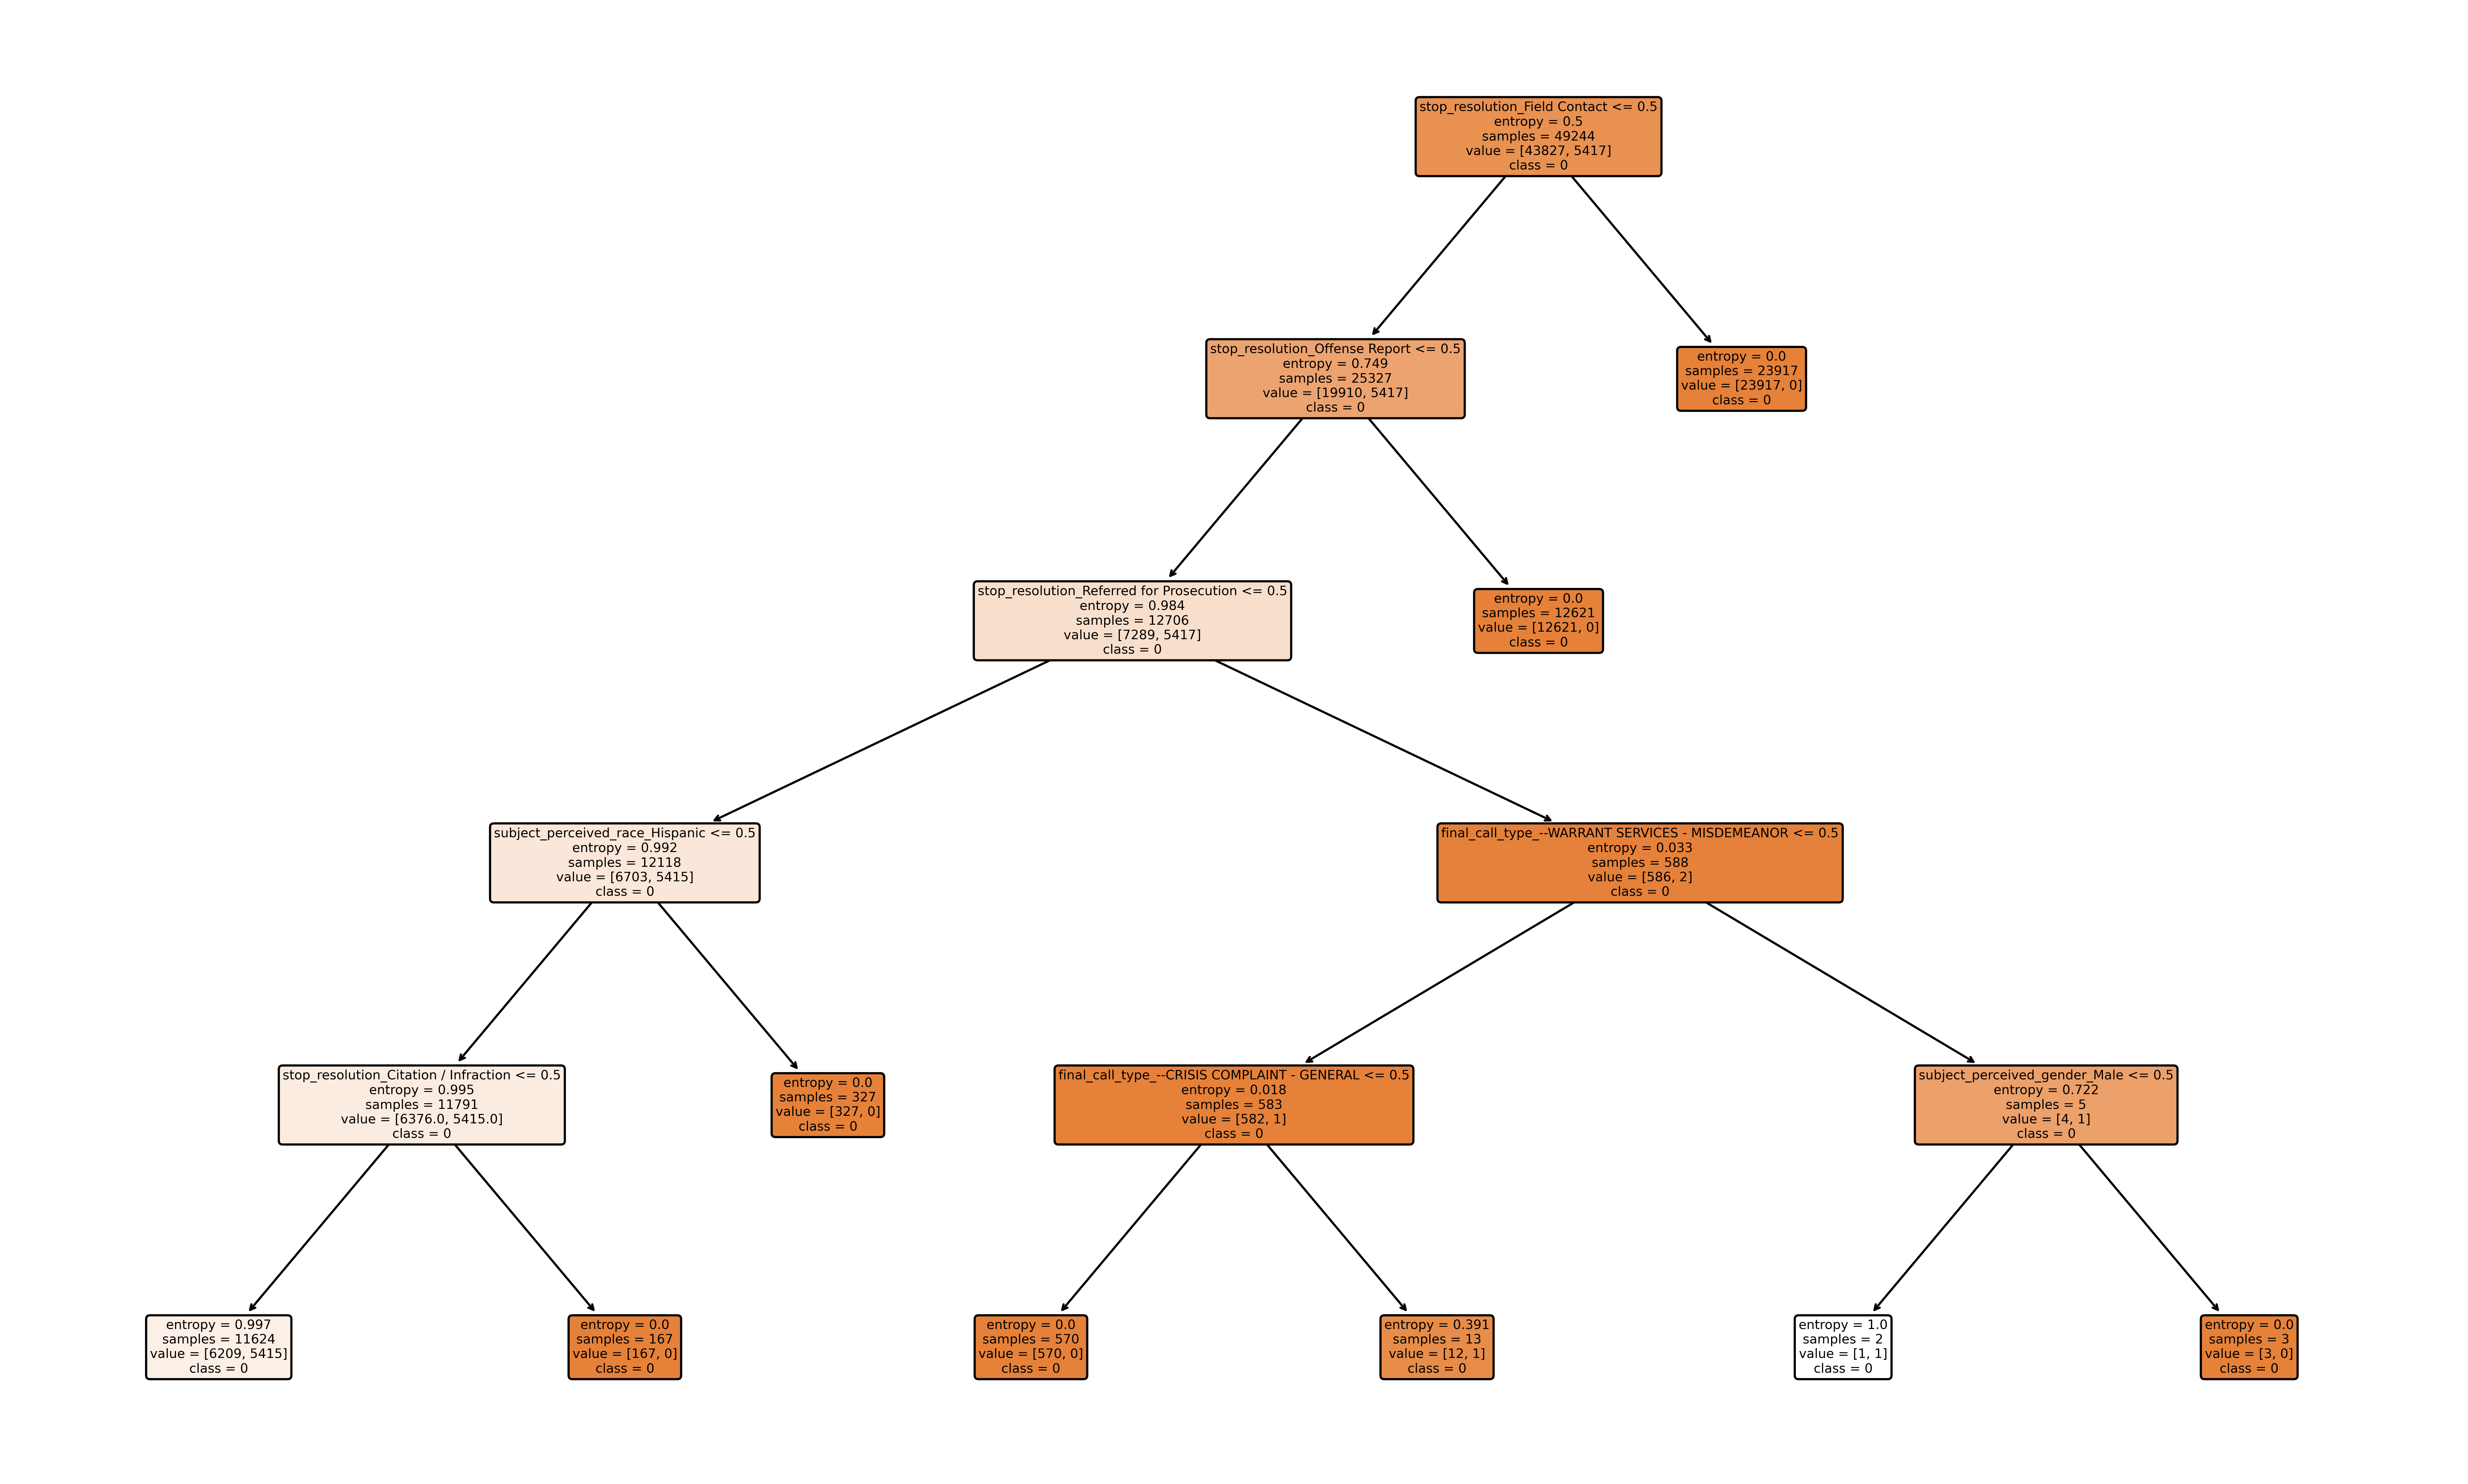

In [51]:
# from sklearn import tree
plt.figure(figsize=(20,12), dpi=500)
tree.plot_tree(dt,
              feature_names=X_train_encoded_df.columns,
              class_names=np.unique(y_train_encoded_series).astype('str'),
              filled=True,
              rounded=True,
              max_depth=10)
plt.show()

We'll start by tuning the max depth for the Classifier

Max Depth: 1, F1 Score: 0.0
Max Depth: 2, F1 Score: 0.0
Max Depth: 3, F1 Score: 0.0
Max Depth: 4, F1 Score: 0.0
Max Depth: 5, F1 Score: 0.4235294117647059
Max Depth: 6, F1 Score: 0.4252651880424301
Max Depth: 7, F1 Score: 0.4727767695099819
Max Depth: 8, F1 Score: 0.4970995091477019
Max Depth: 9, F1 Score: 0.48854262144821264
Max Depth: 10, F1 Score: 0.48794063079777367
Max Depth: 11, F1 Score: 0.48379520901831846
Max Depth: 12, F1 Score: 0.487286176606565
Max Depth: 13, F1 Score: 0.4813591316658801
Max Depth: 14, F1 Score: 0.48233631653320774
Max Depth: 15, F1 Score: 0.5058087578194816
Max Depth: 16, F1 Score: 0.5104490884837706
Max Depth: 17, F1 Score: 0.5086705202312138
Max Depth: 18, F1 Score: 0.5147826086956522
Max Depth: 19, F1 Score: 0.5123323236694072
Max Depth: 20, F1 Score: 0.5168539325842697


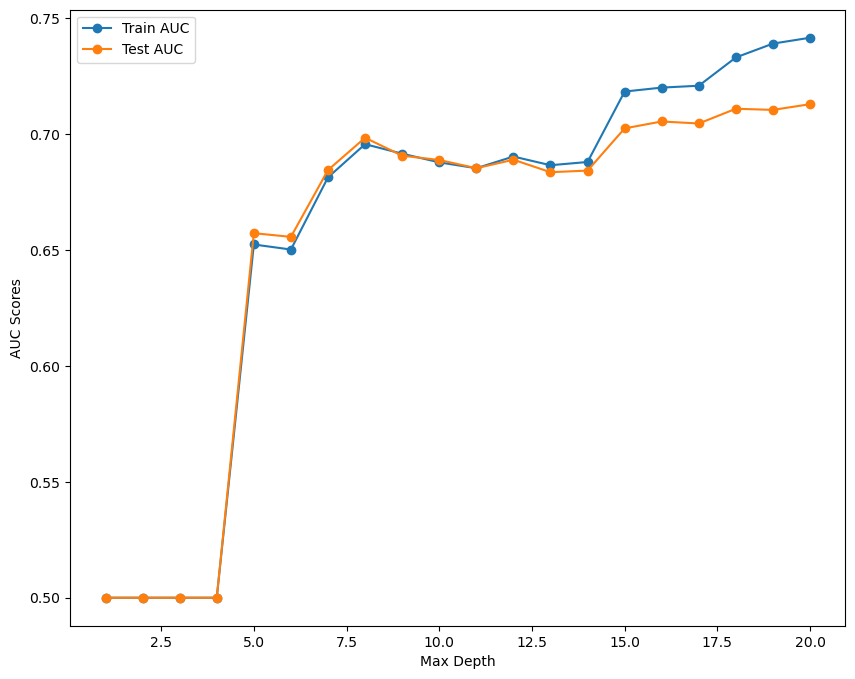

In [52]:
max_depth_values = np.arange(1,21)

train_aucs = []
test_aucs = []

for depth in max_depth_values:
    #Intialize predicted probabilities for training and test sets
    clf = DecisionTreeClassifier(max_depth=depth, random_state=3)
    clf.fit(X_train_encoded_df, y_train_encoded_series)
    
    # Get predicted probabilities for training and test sets
    y_train_prob = clf.predict(X_train_encoded_df)
    y_test_prob = clf.predict(X_test_encoded_df)
    # y_train_prob = clf.predict_proba(X_train_encoded_df)[:,1]
    # y_test_prob = clf.predict_proba(X_test_encoded_df)[:,1]
    
    # Calculate FPR (False Positive Rate), TPR(True Positive Rate) and test sets using roc_curve
    fpr_train, tpr_train, _ = roc_curve(y_train_encoded_series, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test_encoded_series, y_test_prob)
    
    # Calculate AUC absed on FPR and TPR using auc
    train_auc = auc(fpr_train, tpr_train)
    test_auc = auc(fpr_test, tpr_test)
    
    # Append AUC to the list
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

    print(f"Max Depth: {depth}, F1 Score: {f1_score(y_test_encoded_series, y_test_prob)}")
    

# PLot the figure
plt.figure(figsize=(10,8))
plt.plot(max_depth_values, train_aucs, label="Train AUC", marker="o")
plt.plot(max_depth_values, test_aucs, label="Test AUC", marker="o")
plt.xlabel("Max Depth")
plt.ylabel("AUC Scores")
plt.legend()
plt.show()

We see a change in the F1 Score showing a little over half of the data is somewhat balanced.

Min Sample Split: 2, F1 Score: 0.5299
Min Sample Split: 3, F1 Score: 0.5300
Min Sample Split: 4, F1 Score: 0.5337
Min Sample Split: 5, F1 Score: 0.5334
Min Sample Split: 6, F1 Score: 0.5358
Min Sample Split: 7, F1 Score: 0.5329
Min Sample Split: 8, F1 Score: 0.5367
Min Sample Split: 9, F1 Score: 0.5346
Min Sample Split: 10, F1 Score: 0.5361
Min Sample Split: 11, F1 Score: 0.5339
Min Sample Split: 12, F1 Score: 0.5388
Min Sample Split: 13, F1 Score: 0.5368
Min Sample Split: 14, F1 Score: 0.5357
Min Sample Split: 15, F1 Score: 0.5372
Min Sample Split: 16, F1 Score: 0.5333
Min Sample Split: 17, F1 Score: 0.5328
Min Sample Split: 18, F1 Score: 0.5333
Min Sample Split: 19, F1 Score: 0.5319
Min Sample Split: 20, F1 Score: 0.5292


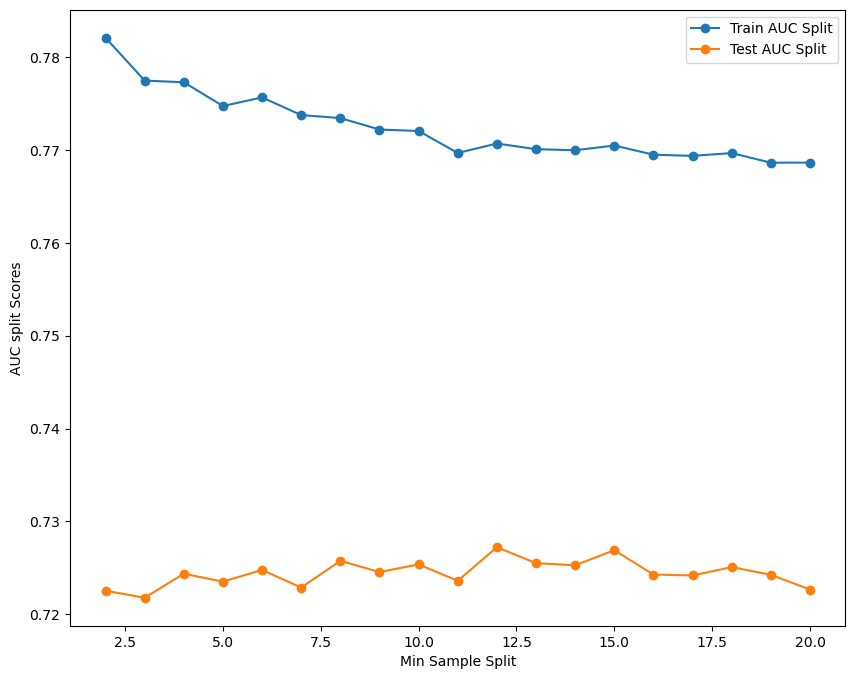

In [53]:
# identify the optimal min-samples-split 
min_sample_splits_value = np.arange(2,21)
train_auc_splits = []
test_auc_splits = []

for split in min_sample_splits_value:
    clf_split = DecisionTreeClassifier(min_samples_split=split, random_state=3)
    clf_split.fit(X_train_encoded_df, y_train_encoded_series)

    y_train_probs = clf_split.predict(X_train_encoded_df)
    y_test_probs = clf_split.predict(X_test_encoded_df)
    # y_train_probs = clf_split.predict_proba(X_train_encoded_df)[:,1]
    # y_test_probs = clf_split.predict_proba(X_test_encoded_df)[:,1]

    fpr_train_split, tpr_train_split, _ = roc_curve(y_train_encoded_series, y_train_probs)
    fpr_test_split, tpr_test_split, _ = roc_curve(y_test_encoded_series, y_test_probs)

    train_auc_split = auc(fpr_train_split, tpr_train_split)
    test_auc_split = auc(fpr_test_split, tpr_test_split)
    
    train_auc_splits.append(train_auc_split)
    test_auc_splits.append(test_auc_split)
    print(f"Min Sample Split: {split}, F1 Score: {f1_score(y_test_encoded_series, y_test_probs):.4f}")


plt.figure(figsize=(10,8))
plt.plot(min_sample_splits_value, train_auc_splits, label="Train AUC Split", marker="o")
plt.plot(min_sample_splits_value, test_auc_splits, label="Test AUC Split", marker="o")
plt.xlabel("Min Sample Split")
plt.ylabel("AUC split Scores")
plt.legend()
plt.show()

In this instance, we see the F1-Score increase to ove half around 54%.

We'll adjust the minimum sample leaf as well.

Min Sample Leaf: 1, F1 Score: 0.52988554472234
Min Sample Leaf: 2, F1 Score: 0.5125977410947002
Min Sample Leaf: 3, F1 Score: 0.5241970021413276
Min Sample Leaf: 4, F1 Score: 0.5298411335337054
Min Sample Leaf: 5, F1 Score: 0.5389473684210526
Min Sample Leaf: 6, F1 Score: 0.5341246290801187
Min Sample Leaf: 7, F1 Score: 0.5354000837871805
Min Sample Leaf: 8, F1 Score: 0.5415617128463476
Min Sample Leaf: 9, F1 Score: 0.5437055625261397
Min Sample Leaf: 10, F1 Score: 0.5433866891322662
Min Sample Leaf: 11, F1 Score: 0.5482657751776013
Min Sample Leaf: 12, F1 Score: 0.5467505241090147
Min Sample Leaf: 13, F1 Score: 0.5494596841230258
Min Sample Leaf: 14, F1 Score: 0.5492783505154639
Min Sample Leaf: 15, F1 Score: 0.5496932515337424
Min Sample Leaf: 16, F1 Score: 0.5483738163853438
Min Sample Leaf: 17, F1 Score: 0.547911547911548
Min Sample Leaf: 18, F1 Score: 0.5474031327287716
Min Sample Leaf: 19, F1 Score: 0.546131568059578
Min Sample Leaf: 20, F1 Score: 0.5462080397845006


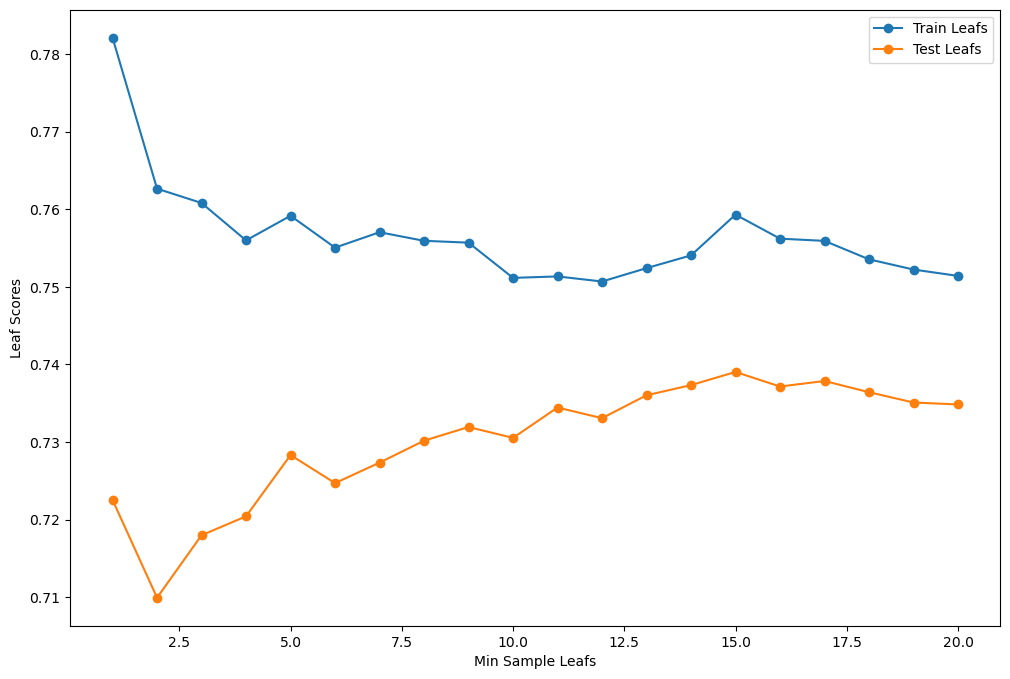

In [54]:
min_sample_leafs_values = np.arange(1,21)
train_auc_leafs = []
test_auc_leafs = []

for leaf in min_sample_leafs_values:
    #instantiate the classifier
    clf_leaf = DecisionTreeClassifier(min_samples_leaf=leaf, random_state=3)
    clf_leaf.fit(X_train_encoded_df, y_train_encoded_series)

    y_train_leaf_pred_prob = clf_leaf.predict(X_train_encoded_df)
    y_test_leaf_pred_prob = clf_leaf.predict(X_test_encoded_df)

    # predict probabilities
    # y_train_leaf_pred_prob = clf_leaf.predict_proba(X_train_encoded_df)[:,1]
    # y_test_leaf_pred_prob = clf_leaf.predict_proba(X_test_encoded_df)[:,1]

    # get the false positive and true positive values
    fpr_train_leaf, tpr_train_leaf, _ = roc_curve(y_train_encoded_series, y_train_leaf_pred_prob)
    fpr_test_leaf, tpr_test_leaf, _ = roc_curve(y_test_encoded_series, y_test_leaf_pred_prob)

    # Get the AUC
    train_auc_leaf = auc(fpr_train_leaf, tpr_train_leaf)
    test_auc_leaf = auc(fpr_test_leaf, tpr_test_leaf)

    train_auc_leafs.append(train_auc_leaf)
    test_auc_leafs.append(test_auc_leaf)
    
    print(f"Min Sample Leaf: {leaf}, F1 Score: {f1_score(y_test_encoded_series, y_test_leaf_pred_prob)}")

plt.figure(figsize=(12,8))
plt.plot(min_sample_leafs_values, train_auc_leafs, label="Train Leafs", marker="o")
plt.plot(min_sample_leafs_values, test_auc_leafs, label="Test Leafs", marker="o")
plt.xlabel("Min Sample Leafs")
plt.ylabel("Leaf Scores")
plt.legend()
plt.show()


Finally, we will decide which ciriterion would work best to optimized this model.

In [55]:
# Calculate probabilities for ROC and Precision-Recall

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
criterion = ['gini', 'entropy']

for crit in criterion:
    dt = DecisionTreeClassifier(criterion=crit, random_state=9).fit(X_train_encoded_df, y_train_encoded_series)
    y_proba = dt.predict(X_test_encoded_df)
    
    print(f"Criterion: {crit}, F1 Score: {f1_score(y_test_encoded_series, y_proba)}")


Criterion: gini, F1 Score: 0.5269868253293668
Criterion: entropy, F1 Score: 0.531236719082023


# Combine the best parameters

We'll combine the best parameters from our hyperparameter tuning and create a new model.

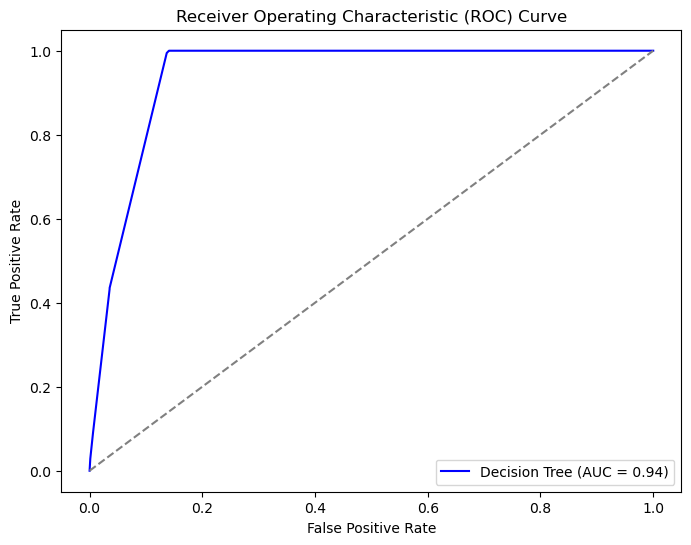

Optimized Decision Tree Performance:

Optimized Accuracy: 0.9088619933392901
Optimized Precision: 0.5869336143308747
Optimized Recall: 0.43278943278943277
Optimized F1 Score: 0.49821109123434704
Optimized ROC AUC: 0.9435491385328105
Confusion Matrix:
 [[10632   392]
 [  730   557]]


In [56]:
dt_optimized = DecisionTreeClassifier(max_depth=9, 
                                      min_samples_split=12, 
                                      min_samples_leaf=15, 
                                      criterion='entropy', 
                                      random_state=9).fit(X_train_encoded_df, y_train_encoded_series)


# Evaluate the model
y_probability_optimized = dt_optimized.predict_proba(X_test_encoded_df)[:, 1]
fpr3, tpr3, _ = roc_curve(y_test_encoded_series, y_probability_optimized)
roc_auc = roc_auc_score(y_test_encoded_series, y_probability_optimized)


# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr3, tpr3, color='blue', label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

y_pred_optimized = dt_optimized.predict(X_test_encoded_df)

print("Optimized Decision Tree Performance:\n")
print(f"Optimized Accuracy: {accuracy_score(y_test_encoded_series, y_pred_optimized)}")
print(f"Optimized Precision: {precision_score(y_test_encoded_series, y_pred_optimized)}")
print(f"Optimized Recall: {recall_score(y_test_encoded_series, y_pred_optimized)}")
print(f"Optimized F1 Score: {f1_score(y_test_encoded_series, y_pred_optimized)}")
print(f"Optimized ROC AUC: {roc_auc}")

print(f"Confusion Matrix:\n {confusion_matrix(y_test_encoded_series,y_pred_optimized)}")


[Text(0.775, 0.95, 'stop_resolution_Field Contact <= 0.5\nentropy = 0.5\nsamples = 49244\nvalue = [43827, 5417]\nclass = NO Arrest'),
 Text(0.725, 0.85, 'stop_resolution_Offense Report <= 0.5\nentropy = 0.749\nsamples = 25327\nvalue = [19910, 5417]\nclass = NO Arrest'),
 Text(0.675, 0.75, 'stop_resolution_Referred for Prosecution <= 0.5\nentropy = 0.984\nsamples = 12706\nvalue = [7289, 5417]\nclass = NO Arrest'),
 Text(0.55, 0.65, 'subject_perceived_race_Hispanic <= 0.5\nentropy = 0.992\nsamples = 12118\nvalue = [6703, 5415]\nclass = NO Arrest'),
 Text(0.5, 0.55, 'stop_resolution_Citation / Infraction <= 0.5\nentropy = 0.995\nsamples = 11791\nvalue = [6376.0, 5415.0]\nclass = NO Arrest'),
 Text(0.45, 0.45, 'officer_race_White <= 0.5\nentropy = 0.997\nsamples = 11624\nvalue = [6209, 5415]\nclass = NO Arrest'),
 Text(0.25, 0.35, 'officer_race_missing_value <= 0.5\nentropy = 0.986\nsamples = 3204\nvalue = [1376.0, 1828.0]\nclass = Arrest'),
 Text(0.15, 0.25, 'subject_perceived_race_Multi-

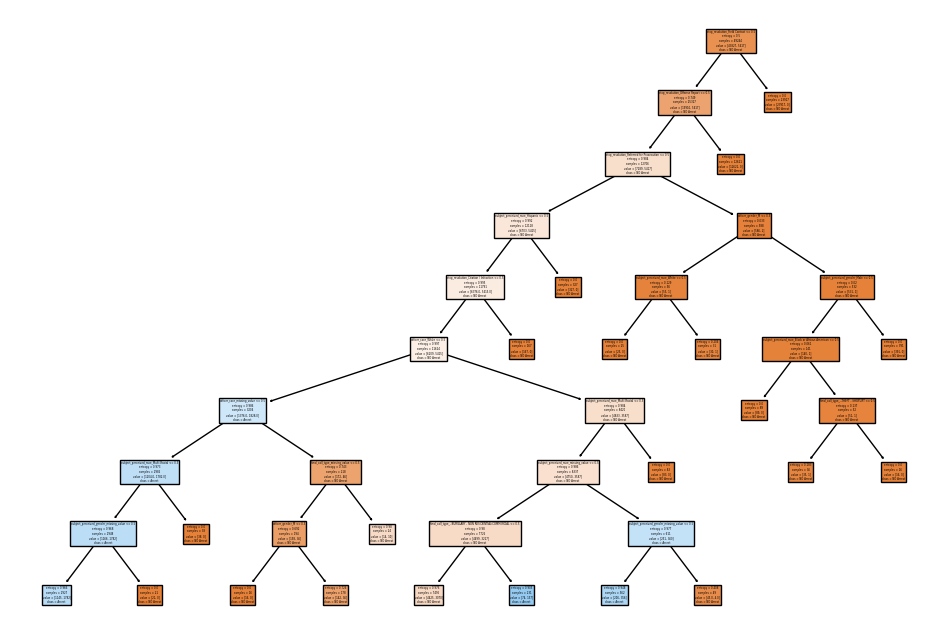

In [57]:
plt.figure(figsize=(12,8))

tree.plot_tree(dt_optimized, feature_names=X_train_encoded_df.columns, class_names=['NO Arrest', 'Arrest'], filled=True)

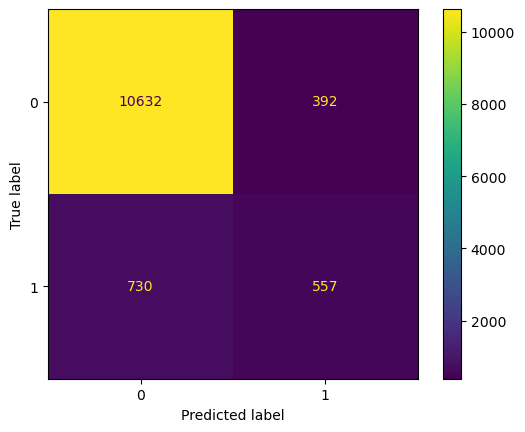

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded_series, y_pred_optimized)

In [59]:
nypd_data.head()

,STOP_ID,STOP_FRISK_DATE,STOP_FRISK_TIME,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,...,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,1,2023-01-01,00:44:00,2023,January,Sunday,Based on Radio Run,APP,POM,804,...,BLUE HOODIE BLUE JEANS,5,A,3B,46 MADISON ST,MADISON ST,984781,198509,PBMS,MANHATTAN
1,2,2023-01-01,00:49:00,2023,January,Sunday,Based on Self Initiated,APP,POM,69,...,UNK,69,B,(null),9910 SEAVIEW AVE,SEAVIEW AVE,1015557,170379,PBBS,BROOKLYN
2,3,2023-01-01,05:31:00,2023,January,Sunday,Based on Radio Run,APP,POM,83,...,NaN,83,D,(null),TROUTMAN ST && ST NICHOLAS AVE,TROUTMAN ST,1005940,197103,PBBN,BROOKLYN
3,4,2023-01-01,04:59:00,2023,January,Sunday,Based on Self Initiated,APP,POM,113,...,(null),113,B,(null),FARMERS BLVD && 135 AVE,FARMERS BLVD,1049830,185439,PBQS,QUEENS
4,5,2023-01-01,05:21:00,2023,January,Sunday,Based on Self Initiated,APP,POF,46,...,(null),46,B,(null),2463 WEBSTER AVE,WEBSTER AVE,1013821,252710,PBBX,BRONX


In [60]:
nypd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16971 entries, 0 to 16970
Data columns (total 82 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   STOP_ID                                                       16971 non-null  int64 
 1   STOP_FRISK_DATE                                               16971 non-null  object
 2   STOP_FRISK_TIME                                               16971 non-null  object
 3   YEAR2                                                         16971 non-null  int64 
 4   MONTH2                                                        16971 non-null  object
 5   DAY2                                                          16971 non-null  object
 6   STOP_WAS_INITIATED                                            16971 non-null  object
 7   RECORD_STATUS_CODE                                            16971 non-null

In [61]:
nypd_data[['STOP_WAS_INITIATED',
           'STOP_DURATION_MINUTES',
           'OFFICER_EXPLAINED_STOP_FLAG',
           'SEARCHED_FLAG',
           'FRISKED_FLAG',
           'SUSPECT_ARREST_OFFENSE', 
           'SUMMONS_ISSUED_FLAG', 'FRISKED_FLAG',
           'SEARCHED_FLAG',
           'SUSPECT_REPORTED_AGE',
           'SUSPECT_SEX',
           'SUSPECT_RACE_DESCRIPTION'
           ]]

,STOP_WAS_INITIATED,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,SEARCHED_FLAG,FRISKED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,FRISKED_FLAG,SEARCHED_FLAG,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION
0,Based on Radio Run,10,Y,N,Y,(null),N,Y,N,32,MALE,BLACK
1,Based on Self Initiated,3,N,Y,Y,CPW,N,Y,Y,23,MALE,WHITE HISPANIC
2,Based on Radio Run,5,Y,N,Y,(null),N,Y,N,30,MALE,WHITE HISPANIC
3,Based on Self Initiated,2,Y,Y,Y,(null),N,Y,Y,20,MALE,BLACK
4,Based on Self Initiated,14,N,Y,Y,CPW,N,Y,Y,25,MALE,BLACK HISPANIC
...,...,...,...,...,...,...,...,...,...,...,...,...
16966,Based on C/W on Scene,3,Y,Y,Y,CRIMINAL TRESPASS,N,Y,Y,22,MALE,WHITE HISPANIC
16967,Based on C/W on Scene,3,Y,Y,Y,CRIMINAL TRESPASS,N,Y,Y,24,MALE,WHITE
16968,Based on C/W on Scene,3,Y,Y,Y,CRIMINAL TRESPASS,N,Y,Y,21,MALE,WHITE
16969,Based on C/W on Scene,3,Y,Y,Y,MENACING,N,Y,Y,45,MALE,ASIAN / PACIFIC ISLANDER


In [62]:
# nypd_data['SUSPECT_ARRESTED_FLAG'] = nypd_data['SUSPECT_ARRESTED_FLAG'].map({"Y": 1, "N": 0})
nypd_data['SUSPECT_ARRESTED_FLAG'].value_counts()

SUSPECT_ARRESTED_FLAG
N    12071
Y     4900
Name: count, dtype: int64

In [63]:
nypd_data['SUSPECT_ARRESTED_FLAG'].isna().sum()

0

In [64]:
for column in nypd_data.columns:
    print(nypd_data[column].value_counts())
    print()

STOP_ID
1        1
11320    1
11306    1
11307    1
11308    1
        ..
5663     1
5664     1
5665     1
5666     1
16971    1
Name: count, Length: 16971, dtype: int64

STOP_FRISK_DATE
2023-03-05    89
2023-01-18    86
2023-05-05    83
2023-10-25    81
2023-10-31    79
              ..
2023-07-17    22
2023-03-13    20
2023-12-06    19
2023-09-18    18
2023-12-25    17
Name: count, Length: 365, dtype: int64

STOP_FRISK_TIME
00:00:00    152
22:30:00     74
23:20:00     62
21:00:00     60
18:15:00     59
           ... 
07:36:00      1
06:04:00      1
05:49:00      1
10:29:00      1
05:42:00      1
Name: count, Length: 1382, dtype: int64

YEAR2
2023    16971
Name: count, dtype: int64

MONTH2
October      1734
May          1647
April        1544
January      1468
July         1439
March        1407
August       1368
December     1353
February     1304
November     1283
June         1254
September    1170
Name: count, dtype: int64

DAY2
Wednesday    2790
Tuesday      2614
Saturday     25

In [86]:
X2 = nypd_data.drop(columns=['STOP_ID',
                     'STOP_LOCATION_FULL_ADDRESS',
                     'STOP_LOCATION_STREET_NAME', 
                     'STOP_LOCATION_X','STOP_LOCATION_Y', 
                     'SUSPECT_ARRESTED_FLAG',
                     'STOP_FRISK_DATE',
                     'STOP_FRISK_TIME',
                     'YEAR2',
                     'MONTH2',
                     'DAY2',
                     'RECORD_STATUS_CODE',
                     'VERBAL_IDENTIFIES_OFFICER_FLAG',
                     'SHIELD_IDENTIFIES_OFFICER_FLAG',
                     'ID_CARD_IDENTIFIES_OFFICER_FLAG'], axis=1
                    )

y2 = nypd_data['SUSPECT_ARRESTED_FLAG']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, random_state=42, test_size=0.30)

In [87]:
X_train2 = X_train2.replace(['(null)','NONE','UNKNOWN','UNK'],np.nan)
X_test2= X_test2.replace(['(null)','NONE','UNKNOWN','UNK'], np.nan)
#encode
# nypd_data['STOP_LOCATION_APARTMENT'] == '(null)'

C:\Users\omend\AppData\Local\Temp\ipykernel_24080\1134541695.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train2 = X_train2.replace(['(null)','NONE','UNKNOWN','UNK'],np.nan)
C:\Users\omend\AppData\Local\Temp\ipykernel_24080\1134541695.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test2= X_test2.replace(['(null)','NONE','UNKNOWN','UNK'], np.nan)


In [91]:
for column in X_train2.columns:
    print(X_train2[column].value_counts())
    print()

STOP_WAS_INITIATED
Based on Self Initiated    5490
Based on Radio Run         5122
Based on C/W on Scene      1267
Name: count, dtype: int64

ISSUING_OFFICER_RANK
POM    5773
PO     4490
POF     773
SGT     319
DTS     250
DT3     126
LT       86
SSA      25
DT2       9
LSA       8
SDS       7
CPT       7
DI        5
DT1       1
Name: count, dtype: int64

ISSUING_OFFICER_COMMAND_CODE
46     1118
48      564
40      487
52      385
44      380
       ... 
567       1
613       1
276       1
504       1
234       1
Name: count, Length: 175, dtype: int64

SUPERVISING_OFFICER_RANK
SGT    8879
LT     2486
SSA     317
CPT      60
LSA      51
SDS      38
POM      15
PO       13
DI        9
LCD       5
DT3       2
INS       2
DC        1
POF       1
Name: count, dtype: int64

SUPERVISING_OFFICER_COMMAND_CODE
46     1135
48      553
40      451
44      379
42      279
       ... 
547       1
206       1
341       1
881       1
234       1
Name: count, Length: 178, dtype: int64

SUPERVISING_ACTI

In [92]:
X_train2 = reformat_columns(X_train2)
X_test2 = reformat_columns(X_test2)
y_train2 = reformat_columns(y_train2)
y_test2 = reformat_columns(y_test2)

X_train2.columns

Index(['stop_was_initiated', 'issuing_officer_rank',
       'issuing_officer_command_code', 'supervising_officer_rank',
       'supervising_officer_command_code',
       'supervising_action_corresponding_activity_log_entry_reviewed',
       'location_in_out_code', 'jurisdiction_code', 'jurisdiction_description',
       'observed_duration_minutes', 'suspected_crime_description',
       'stop_duration_minutes', 'officer_explained_stop_flag',
       'officer_not_explained_stop_description', 'other_person_stopped_flag',
       'suspect_arrest_offense', 'summons_issued_flag',
       'summons_offense_description', 'officer_in_uniform_flag',
       'frisked_flag', 'searched_flag', 'ask_for_consent_flg',
       'consent_given_flg', 'other_contraband_flag', 'firearm_flag',
       'knife_cutter_flag', 'other_weapon_flag', 'weapon_found_flag',
       'physical_force_cew_flag', 'physical_force_draw_point_firearm_flag',
       'physical_force_handcuff_suspect_flag',
       'physical_force_oc_spray_

In [93]:
y_train2.name

'suspect_arrested_flag'

In [94]:
nypd_imputer = SimpleImputer(strategy='most_frequent', fill_value=None)
nypd_imputer.fit(X_train2)


# transform the features
X_train_imputed_nypd = nypd_imputer.transform(X_train2)
X_test_imputed_nypd = nypd_imputer.transform(X_test2)

X_train_imputed_nypd_df = pd.DataFrame(X_train_imputed_nypd,
                                columns=X_train2.columns, 
                                index=X_train2.index
                                )


X_test_imputed_nypd_df = pd.DataFrame(X_test_imputed_nypd, 
                                columns=X_test2.columns, 
                                index=X_test2.index
                                )

X_test_imputed_nypd_df

,stop_was_initiated,issuing_officer_rank,issuing_officer_command_code,supervising_officer_rank,supervising_officer_command_code,supervising_action_corresponding_activity_log_entry_reviewed,location_in_out_code,jurisdiction_code,jurisdiction_description,observed_duration_minutes,...,suspect_weight,suspect_body_build_type,suspect_eye_color,suspect_hair_color,suspect_other_description,stop_location_precinct,stop_location_sector_code,stop_location_apartment,stop_location_patrol_boro_name,stop_location_boro_name
6109,Based on C/W on Scene,POM,30,SGT,30,N,O,P,PSB,1,...,150.0,THN,BLK,BLK,BLACK JACKET,30,B,1,PBMN,MANHATTAN
4715,Based on Self Initiated,POM,32,SGT,32,Y,O,P,PSB,5,...,200.0,MED,BLK,BLK,BLACK JACKET,32,D,1,PBMN,MANHATTAN
14212,Based on Radio Run,PO,20,SGT,20,Y,O,P,PSB,1,...,180.0,MED,BRO,BLD,BLACK JACKET,20,B,1,PBMN,MANHATTAN
8197,Based on Radio Run,POM,109,SGT,109,Y,O,P,PSB,1,...,150.0,MED,BRO,BLK,BLACK HOODIE BLACK HATBLACK SWEATS BLACK SHOES,109,B,1,PBQN,QUEENS
10251,Based on Self Initiated,SSA,803,LT,803,Y,O,P,PSB,2,...,150.0,MED,BLK,BLK,BLACK JACKET,81,A,1,PBBN,BROOKLYN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5800,Based on Self Initiated,POM,46,SGT,46,Y,O,P,PSB,2,...,170.0,THN,BRO,BLK,BLACK JACKET,46,A,1,PBBX,BRONX
6983,Based on Self Initiated,PO,32,SGT,32,Y,O,P,PSB,0,...,150.0,MED,BRO,BLK,BLACK JACKET,32,D,1,PBMN,MANHATTAN
9140,Based on Radio Run,POM,67,LT,67,Y,I,P,PSB,1,...,170.0,THN,BRO,BLK,BEARD,67,A,1,PBBS,BROOKLYN
13837,Based on Radio Run,PO,6,LT,6,Y,O,P,PSB,1,...,130.0,THN,ZZZ,BLK,BLACK JACKET,6,A,1,PBMS,MANHATTAN


In [96]:
# X_train2_numeric = X_train_imputed_nypd_df.select_dtypes(exclude='object')
# X_train2_categorical = X_train_imputed_nypd_df.select_dtypes(include='object')
# X_test2_numeric = X_train_imputed_nypd_df.select_dtypes(exclude='object')
# X_test2_categorical = X_train_imputed_nypd_df.select_dtypes(include='object')

# X_train2_numeric
X_train_imputed_nypd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11879 entries, 12177 to 15795
Data columns (total 67 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   stop_was_initiated                                            11879 non-null  object
 1   issuing_officer_rank                                          11879 non-null  object
 2   issuing_officer_command_code                                  11879 non-null  object
 3   supervising_officer_rank                                      11879 non-null  object
 4   supervising_officer_command_code                              11879 non-null  object
 5   supervising_action_corresponding_activity_log_entry_reviewed  11879 non-null  object
 6   location_in_out_code                                          11879 non-null  object
 7   jurisdiction_code                                             11879 non-null 

In [100]:
y_train2.info()

<class 'pandas.core.series.Series'>
Index: 11879 entries, 12177 to 15795
Series name: suspect_arrested_flag
Non-Null Count  Dtype 
--------------  ----- 
11879 non-null  object
dtypes: object(1)
memory usage: 185.6+ KB


In [101]:

#create an instance of StandardScaler
nypd_encoder = LabelEncoder()

# Fit and transform train
y_train_nypd_encoded = nypd_encoder.fit_transform(y_train2)

# Transofrm test
y_test_nypd_encoded = nypd_encoder.transform(y_test2)

#convert to a Series
y_train_encoded_nypd_series = pd.Series(y_train_nypd_encoded, index=y_train2.index, name=y_train2.name)

y_test_encoded_nypd_series = pd.Series(y_test_nypd_encoded, index=y_test2.index, name=y_test2.name)

In [102]:
y_train_encoded_nypd_series.info()

<class 'pandas.core.series.Series'>
Index: 11879 entries, 12177 to 15795
Series name: suspect_arrested_flag
Non-Null Count  Dtype
--------------  -----
11879 non-null  int32
dtypes: int32(1)
memory usage: 139.2 KB


In [82]:
y_test_encoded_nypd_series.name

'suspect_arrested_flag'

In [106]:
X_train2_encoded, X_test2_encoded, encoded_columns2 = one_hot_encode(X_train_imputed_nypd_df, X_test_imputed_nypd_df)

X_train2_encoded

c:\Users\omend\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 9, 11, 13, 15, 52, 53, 56, 57, 59, 60, 61, 64] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,stop_was_initiated_Based on Radio Run,stop_was_initiated_Based on Self Initiated,issuing_officer_rank_DI,issuing_officer_rank_DT1,issuing_officer_rank_DT2,issuing_officer_rank_DT3,issuing_officer_rank_DTS,issuing_officer_rank_LSA,issuing_officer_rank_LT,issuing_officer_rank_PO,...,stop_location_patrol_boro_name_PBBX,stop_location_patrol_boro_name_PBMN,stop_location_patrol_boro_name_PBMS,stop_location_patrol_boro_name_PBQN,stop_location_patrol_boro_name_PBQS,stop_location_patrol_boro_name_PBSI,stop_location_boro_name_BROOKLYN,stop_location_boro_name_MANHATTAN,stop_location_boro_name_QUEENS,stop_location_boro_name_STATEN ISLAND
12177,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5711,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5116,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15684,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13411,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11964,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [108]:
X_test2_encoded

,stop_was_initiated_Based on Radio Run,stop_was_initiated_Based on Self Initiated,issuing_officer_rank_DI,issuing_officer_rank_DT1,issuing_officer_rank_DT2,issuing_officer_rank_DT3,issuing_officer_rank_DTS,issuing_officer_rank_LSA,issuing_officer_rank_LT,issuing_officer_rank_PO,...,stop_location_patrol_boro_name_PBBX,stop_location_patrol_boro_name_PBMN,stop_location_patrol_boro_name_PBMS,stop_location_patrol_boro_name_PBQN,stop_location_patrol_boro_name_PBQS,stop_location_patrol_boro_name_PBSI,stop_location_boro_name_BROOKLYN,stop_location_boro_name_MANHATTAN,stop_location_boro_name_QUEENS,stop_location_boro_name_STATEN ISLAND
6109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4715,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14212,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8197,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
10251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6983,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13837,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [110]:
nypd_logreg = LogisticRegression(random_state=45, max_iter=1000)

nypd_logreg.fit(X_train2_encoded, y_train_encoded_nypd_series)

y_pred_nypd = nypd_logreg.predict(X_test2_encoded)

# Calculate evaluation metrics
accuracy_nypd_logreg = accuracy_score(y_test_encoded_nypd_series, y_pred_nypd)
precision_nypd_logreg = precision_score(y_test_encoded_nypd_series, y_pred_nypd, pos_label=1)
recall_nypd_logreg = recall_score(y_test_encoded_nypd_series, y_pred_nypd, pos_label=1)
f1_nypd_logreg = f1_score(y_test_encoded_nypd_series, y_pred_nypd, pos_label=1)

# Probabilities
y_nypd_probabilites = nypd_logreg.predict_proba(X_test2_encoded)[:,1]

false_positive2, true_positive2, _ = roc_curve(y_test_encoded_nypd_series, y_nypd_probabilites)

roc_auc_nypd = auc(false_positive2, true_positive2)



# Display results

print(f"Accuracy: {accuracy_nypd_logreg}")
print(f"Precision: {precision_nypd_logreg}")
print(f"Recall:  {recall_nypd_logreg}")
print(f"F1 Score: {f1_nypd_logreg}")
print(f"ROC AUC Score: {roc_auc_nypd}")
print()

# Confusion Matrix
conf_matrix_nypd = confusion_matrix(y_test_encoded_nypd_series, y_pred_nypd)
print(f"Confusion Matrix:\n {conf_matrix_nypd}")

Accuracy: 0.9664179104477612
Precision: 0.9540150995195608
Recall:  0.9303882195448461
F1 Score: 0.9420535411724839
ROC AUC Score: 0.9931290848031742

Confusion Matrix:
 [[3531   67]
 [ 104 1390]]


These metrics indicate that the model is perfectly predicting the target variable. Here's what each metric says about the model's performance:

## Metrics Interpretation:
1. Accuracy (96.64%)
What it means: The model correctly classified 96.64% of the cases in the test set.
Interpretation: High accuracy suggests the model performs well overall. However, it doesn't distinguish between class imbalances (e.g., if one class dominates the dataset).
2. Precision (95.40%)
What it means: Of all the cases predicted as positive (arrested), 95.40% were true positives.
Interpretation: High precision means the model makes few false positive errors (cases where it predicted arrest but no arrest occurred). This is important if false positives are costly (e.g., wrongfully classifying stops as resulting in arrests).
3. Recall (93.04%)
What it means: The model correctly identified 93.04% of all actual positive cases (arrests).
Interpretation: High recall means the model rarely misses positive cases (arrests). This is crucial if the priority is to ensure most arrests are identified, even at the cost of occasional false positives.
4. F1 Score (94.21%)
What it means: The harmonic mean of precision and recall.
Interpretation: A high F1 score suggests the model balances precision and recall well, which is ideal when both false positives and false negatives matter.
5. ROC AUC Score (99.31%)
What it means: The model's ability to distinguish between positive and negative cases across all classification thresholds.
Interpretation: A near-perfect ROC AUC score indicates excellent discriminatory power. The model is highly effective at ranking positive cases (arrests) higher than negative cases (non-arrests).

Strengths: The model performs very well overall, with a good balance between precision and recall.
Weaknesses:
There are still 104 false negatives, meaning 104 arrests were missed.
The false positive rate (67 cases) is small but might need review depending on the cost of such errors.
